# About this notebook
- **Version 1 :**
    + PyTorch CoAT starter code
    + 5 folds
    + OneCycleLR scheduler
    

- **Version 3 :**
    + PyTorch CoAT Model starter code :
    + fixing bugs
    + 5 folds
    + OneCycleLR scheduler

If this notebook is helpful, feel free to upvote :)

In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 703.5 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 2.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=108e7da8de82e8c4ef2e24033215c27e44fd3fc3297ab9e18ba7596a9a83e9e6
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=5824c06c330ff403aa4556c731781c7de20d784886454b63fcf2eb178bcd7faf
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
import sys
import os
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp


print(f"Segmentation Models version: {smp.__version__}")

Segmentation Models version: 0.3.1


# Data Loading

(7680, 7680)


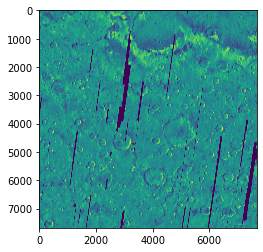

In [13]:
path = '/kaggle/input/mars-craters-dataset'
from skimage import io
img = io.imread(os.path.join(path,'thm_dir_N-30_000.png' ))
print(img.shape)
plt.imshow(img)
plt.show()

# Library

In [33]:
import os
import gc
import sys
import glob
import random
import time
import math
import pathlib

import torch
import torch.nn as nn
import albumentations as A
import skimage
from contextlib import contextmanager

import cv2
import pandas as pd
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from albumentations import *
from torch.optim import Adam, SGD, AdamW
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from torchmetrics import Metric
import tqdm
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import torchvision
from segmentation_models_pytorch.encoders import encoders
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import ImageOnlyTransform

import tifffile as tiff


from torch.nn.utils import weight_norm, spectral_norm


torch.backends.cudnn.benchmark = True

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Config

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    train=True
    debug=False
    ENCODER = 'resnet50'
    DECODER = 'UnetPlusPlus'
    EPOCHS = 60
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':10,
        'eta_min':1e-4*0.5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':5,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':10,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    # OneCycleLR params
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e1,
        'max_lr':1e-3,
        'steps_per_epoch':3, 
        'epochs':3
    }
    preds_col = 'Prediction'
    lr=1e-3
    weight_decay=1e-4
    fold = 0
    nfolds = 5
    imsize = 256
    BATCH_SIZE = 32
    print_freq=100
    DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
    NUM_WORKERS = 4
    SEED = 24
    trn_folds=[0, 1, 2, 3, 4]
    model_name = 'resnext101'
    resolution = (256,256)
    deepsupervision = True
    clfhead = True
    clf_threshold = None

# Utils

In [34]:
# ====================================================
# Utils
# ====================================================
class DiceCoef(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, y_pred, y_true, smooth=1.):
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)
        #Round off y_pred
        y_pred = torch.round((y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()))
        
        intersection = (y_true * y_pred).sum()
        dice = (2.0*intersection + smooth)/(y_true.sum() + y_pred.sum() + smooth)
        
        return dice

# your Metric 
class Dice_soft(Metric):
    def __init__(self, axis=1):
        self.axis = axis
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, pred, targ):
        pred = torch.sigmoid(pred)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()
    @property
    def value(self): return 2.0 * self.inter/self.union if self.union > 0 else None

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=CFG.SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.SEED)

# CV split

# Dataset

In [12]:
# ====================================================
# Dataset
# ====================================================
class HuBMAPDataset(torch.utils.data.Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        ids = self.df.id.values
        self.image_size = CFG.imsize
        self.tfms = tfms
        
    def img2tensor(self, img,dtype:np.dtype=np.float32):
        if img.ndim==2 : img = np.expand_dims(img,2)
        img = np.transpose(img,(2,0,1)) # C , H , W
        return torch.from_numpy(img.astype(dtype, copy=False))
    
    def __len__(self):
        return len(self.fnames)
    
    def resize(self, img, interp):
        return  cv2.resize(
            img, (self.image_size, self.image_size), interpolation=interp)
    
    def __getitem__(self, idx):
        img = cv2.cvtColor(df.iloc[idx]['image_path'], cv2.COLOR_BGR2RGB)
        mask = cv2.imread((MASK_PATH + fname),cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        
        return self.img2tensor(self.resize(img , cv2.INTER_NEAREST)) , self.img2tensor(self.resize(mask , cv2.INTER_NEAREST))

# Transforms

(256, 256)


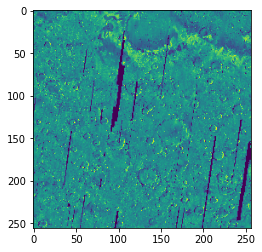

In [21]:
def Resize_fn(p=1.0):
    return A.Compose([
        A.Resize(256,256)
    ])
tfms=Resize_fn()
augmented = tfms(image=img)
resized_image = augmented['image']
print(resized_image.shape)
plt.imshow(resized_image)

In [ ]:
def get_aug(p=1.0):
    return A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.5),

    # brightness_aug
    A.OneOf([
        A.RandomBrightnessContrast(p=1.0, contrast_limit=(-0.2, 0.2), brightness_limit=(-0.1, 0.1)),
        A.HueSaturationValue(p=1.0,always_apply=False,hue_shift_limit=(-30, 30),sat_shift_limit=(-90, 20),val_shift_limit=(-20, 20),),
        A.RandomGamma(p=0.5, gamma_limit=(50, 200)),
    ],
        p=1.0,),
     A.OneOf([
        A.ChannelShuffle(p=0.1),
        A.ColorJitter(p=0.1),
        A.FancyPCA(p=0.1),
        A.augmentations.transforms.CLAHE(p=0.1),
    ],
         p=1.0),
        
        
    # distortion_aug
    A.OneOf([
        A.OpticalDistortion(p=0.3), 
        A.GridDistortion(p=0.3), 
        A.ElasticTransform(p=0.1)
    ], 
        p=1.0),

    # noise_aug
    A.OneOf([
        A.Blur(always_apply=False, p=1.0, blur_limit=(3, 7)),
        A.GaussNoise(always_apply=False, p=1.0, var_limit=(10.0, 50.0)),
        A.MultiplicativeNoise(always_apply=False, p=1.0, multiplier=(0.9, 1.1), per_channel=True, elementwise=True),
    ],
        p=1.0),
        
    #A.OneOf([
    #    A.HueSaturationValue(10,15,10),
    #    A.CLAHE(clip_limit=2),
    #    A.RandomBrightnessContrast(),            
    #], p=0.3),
])

# MODEL

In [27]:
DECODERS = [
    "Unet",
    "Linknet",
    "FPN",
    "PSPNet",
    "DeepLabV3",
    "DeepLabV3Plus",
    "PAN",
    "UnetPlusPlus",
]
ENCODERS = list(encoders.keys())


def define_model(
    decoder_name = CFG.model_name,
    encoder_name = "Unet",
    num_classes=1,
    activation=None,
    encoder_weights="imagenet",
):
    """
    Loads a segmentation architecture.
    Args:
        decoder_name (str): Decoder name.
        encoder_name (str): Encoder name.
        num_classes (int, optional): Number of classes. Defaults to 1.
        pretrained : pretrained original weights
        activation (str or None, optional): Activation of the last layer. Defaults to None.
        encoder_weights (str, optional): Pretrained weights. Defaults to "imagenet".
    Returns:
        torch model: Segmentation model.
    """
    assert decoder_name in DECODERS, "Decoder name not supported"
    assert encoder_name in ENCODERS, "Encoder name not supported"

    decoder = getattr(smp, decoder_name)

    model = decoder(
        encoder_name,
        encoder_weights=encoder_weights,
        classes=num_classes,
        activation=activation,
    )
    model.num_classes = num_classes

    return model

In [29]:
model =define_model(encoder_name=CFG.ENCODER,decoder_name=CFG.DECODER)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Loss

In [ ]:
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):

        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()

        return 1 - dc

In [ ]:
# ====================================================
# Loss function
# ====================================================
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()
        self.diceloss = smp.losses.DiceLoss(mode='binary')
        self.binloss = smp.losses.SoftBCEWithLogitsLoss(reduction = 'mean' , smooth_factor = 0.1)
        
    def forward(self, outputs, mask):
        dice = self.diceloss(outputs,mask)
        bce = self.binloss(outputs , mask)
        loss = dice * 0.7 + bce * 0.3
        return loss

# Helper functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def train_fn(train_loader, model, criterion, metric , optimizer, scheduler,epoch, DEVICE):
    
    metric.reset()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    train_loss=0.0
    score=0.0
    # switch to train mode
    model.train()
    start = end = time.time()
    for step, data in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        img, mask = data
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)
        batch_size = img.size(0)
    
        outputs = model(img)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #loss
        #loss = loss.detach().item()
        train_loss += loss.item()
        #score += metric(outputs,mask).item()
        metric.accumulate(outputs.detach(), mask)
        # record loss
        losses.update(loss.item(), batch_size)
        #scores.update(metric(outputs,mask).item(), batch_size)
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
            
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  #'Score: {score.val:.4f}'
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          #score=scores,
                          lr=scheduler.get_lr()[0]
                         ))
    TRAIN_LOSS = train_loss / len(train_loader)
    #SCORE = score / len(train_loader)
    metric_this_epoch=metric.value
    return TRAIN_LOSS , metric_this_epoch
    
def valid_fn(valid_loader, model, criterion,metric,epoch ,DEVICE):
    metric.reset()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    preds=[]
    valid_loss=0.0
    val_score=0.0
    # switch to evaluation mode
    model.eval()
    start = end = time.time()
    
    for step, data in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        img, mask = data
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)
        batch_size = img.size(0)
        # compute loss
        with torch.no_grad():
            outputs = model(img)
        output_tuple = torch.unbind(outputs, dim=0)
        preds.append(output_tuple)
        loss = criterion(outputs, mask)
        valid_loss += loss.item()
        #val_score += metric(outputs,mask).item()
        losses.update(loss.item(), batch_size)
        #scores.update(metric(outputs,mask).item(), batch_size)
        metric.accumulate(outputs.detach(), mask)
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    #'Score: {score.val:.4f}'
                    .format(step, len(valid_loader),
                            loss=losses,
                            #score=scores,
                            remain=timeSince(start, float(step+1)/len(valid_loader))))
    VALID_LOSS = valid_loss / len(valid_loader)
    #VALID_SCORE = val_score / len(valid_loader)
    predictions = [item for t in preds for item in t]
    metric_this_epoch=metric.value
    return VALID_LOSS, metric_this_epoch , predictions

# Train loop

In [ ]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")
    
    # ====================================================
    # loader
    # ====================================================
    if CFG.debug:
        train_folds = folds[folds['fold'] != fold].sample(20)
        valid_folds = folds[folds['fold'] == fold].sample(20)
        
    else:
        train_folds = folds[folds['fold'] != fold]
        valid_folds = folds[folds['fold'] == fold]
        
    train_folds = train_folds.reset_index(drop=True)
    valid_folds = train_folds.reset_index(drop=True)
        
    best_loss = 999
    best_score = 0
    
    ds_train = HuBMAPDataset(df=train_folds, tfms=get_aug())
    ds_val = HuBMAPDataset(df=valid_folds)
    
    dataloader_train = torch.utils.data.DataLoader(ds_train,batch_size=CFG.BATCH_SIZE, shuffle=True,num_workers=CFG.NUM_WORKERS)
    dataloader_val = torch.utils.data.DataLoader(ds_val,batch_size=CFG.BATCH_SIZE, shuffle=False,num_workers=CFG.NUM_WORKERS)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
        return scheduler
    
    # ====================================================
    # model & optimizer
    # ====================================================
    model = define_model(encoder_name=CFG.ENCODER,decoder_name=CFG.DECODER).to(CFG.DEVICE)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.2,
                                                  div_factor=1e2, max_lr=1e-4, epochs=CFG.EPOCHS,
                                                  steps_per_epoch=len(dataloader_train))
    loss_func=nn.BCEWithLogitsLoss()
    dice_coe=Dice_soft()
    
    for epoch in range(CFG.EPOCHS):
        start_time = time.time()
        
        # train
        train_loss, train_score = train_fn(dataloader_train, model, loss_func, dice_coe, optimizer, scheduler, epoch, CFG.DEVICE)
        
        # eval
        valid_loss, val_score , predictions = valid_fn(dataloader_val, model, loss_func, dice_coe, epoch, CFG.DEVICE)

        scheduler.step()
        
        # scoring
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - train_loss: {train_loss:.4f}  train_score: {train_score:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - valid_loss: {valid_loss:.4f}  val_score: {val_score:.4f}')
        
        if val_score > best_score:
            best_score = val_score
            torch.save(model.state_dict(),
                        f"{OUTPUT_DIR}FOLD{fold}_best_score.pth")
            print(f"Saved model for best score : FOLD{fold}_best_score.pth")
            LOGGER.info(f"Saved model for best score : FOLD{fold}_best_score.pth")
        

# Main

In [ ]:
# ====================================================
# main
# ====================================================
def main():

    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.nfolds):
            if fold in CFG.trn_folds:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
if __name__ == "__main__":
    main()